In [1]:
import torchrdit
import numpy as np
import matplotlib.pyplot as plt
import torch
import time

from torchrdit.solver import RCWASolver, RDITSolver
from torchrdit.utils import operator_proj, create_material
from tqdm import tqdm, trange

# Example 1 - GMRF with hexagonal unit cells

This example shows the simulation of the guided-mode resonance filter (GMRF) using torchrdit with differentiable RCWA algorithm. The device is composed of a SiO hexagonal grating layer, a SiN waveguide layer and a fused silica substrate.

The GMRF can be found in the following references:

- A. A. Mehta, R. C. Rumpf, Z. A. Roth, and E. G. Johnson, “Guided mode resonance filter as a spectrally selective feedback element in a double-cladding optical fiber laser,” IEEE Photonics Technology Letters, vol. 19, pp. 2030–2032, 12 2007.

In [2]:
# units, normalizing all units to 'um'
um = 1
nm = 1e-3 * um
degrees = np.pi / 180

# angles of incident waves
theta = 0 * degrees
phi = 0 * degrees

# polarization
pte = 1
ptm = 0

# refractive index
n_SiO = 1.4496
n_SiN = 1.9360
n_fs = 1.5100

# dimensions of the cell
a = 1150 * nm
b = a * np.sqrt(3)

# radius of the holes on the top layer
r = 400 * nm

# thickness of each layer
h1 = torch.tensor(230 * nm, dtype=torch.float32)
h2 = torch.tensor(345 * nm, dtype=torch.float32)

# lattice vectors of the cell
t1 = torch.tensor([a/2, -a*np.sqrt(3)/2], dtype=torch.float32)
t2 = torch.tensor([a/2, a*np.sqrt(3)/2], dtype=torch.float32)

# creating materials
# all mateiral objects should be added to the 'materiallist' parameter when initializing the solver
material_sio = create_material(name='SiO', permittivity=n_SiO**2)
material_sin = create_material(name='SiN', permittivity=n_SiN**2)
material_fs = create_material(name='FusedSilica', permittivity=n_fs**2)

# Initialize the instance of the solver engine
dev1 = RDITSolver(rdim = [512, 512],
                  kdim = [9, 9],
                  lam0 = np.array([1540 * nm, 1550 * nm, 1560 * nm, 1570 * nm]),
                  lengthunit = 'um',
                  t1 = t1,
                  t2 = t2)

# update the material of the transmission layer
dev1.update_trn_material(trn_material=material_fs)

# add a grating layer with patterns, the pattern can be updated later
dev1.add_layer(material_name=material_sio,
              thickness=h1,
              is_homogeneous=False,
              is_optimize=True)

# add a homongeneous layer
dev1.add_layer(material_name=material_sin,
              thickness=h2,
              is_homogeneous=True,
              is_optimize=False)

# print layer information
dev1.get_layer_structure()

# create a source object
src1 = dev1.add_source(theta = theta,
                 phi = phi,
                 pte = pte,
                 ptm = ptm)

------------------------------------
Cell Type: Other
------------------------------------
layer # Reflection
	material name: air
	permittivity: (1+0j)
	permeability: (1+0j)
------------------------------------
layer # 0
	material name: SiO
	thinkness = 0.23000000417232513
	dispersive: False
	homogeneous: False
	to be optimized: True
------------------------------------
layer # 1
	material name: SiN
	thinkness = 0.3449999988079071
	dispersive: False
	homogeneous: True
	to be optimized: False
------------------------------------
layer # Transmission
	material name: FusedSilica
	permittivity: (2.2801+0j)
	permeability: (1+0j)
------------------------------------


In [3]:
# build hexagonal unit cell
rsq = dev1.XO ** 2 + (dev1.YO - b / 2) ** 2
mask = (rsq <= r ** 2)
rsq = dev1.XO ** 2 + (dev1.YO + b / 2) ** 2
mask = mask | (rsq <= r ** 2)
rsq = (dev1.XO - a / 2) ** 2 + dev1.YO ** 2
mask = mask | (rsq <= r ** 2)
rsq = (dev1.XO + a / 2) ** 2 + dev1.YO ** 2

mask = mask | (rsq <= r ** 2)

mask = (~ mask)

dev1.update_er_with_mask(mask=mask, layer_index=0, set_grad = True)

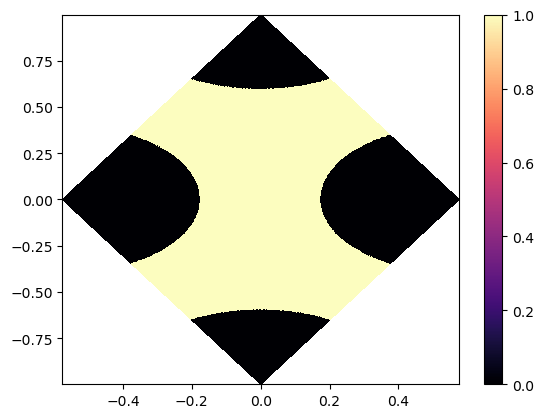

In [4]:
figa, axa = plt.subplots(1, 1)
pcolor_obj = axa.pcolor(dev1.XO.numpy(), dev1.YO.numpy(), mask, vmax=np.real(mask).max(), vmin=np.real(mask).min(), cmap='magma')
plt.colorbar(pcolor_obj, ax=axa)

In [5]:
data = dev1.solve(src1)# Example 1 - GMRF with hexagonal unit cells

In [6]:
print(f"The transmission efficiency is {data['TRN'][0] * 100}%")
print(f"The reflection efficiency is {data['REF'][0] * 100}%")

The transmission efficiency is 92.20940597579191%
The reflection efficiency is 7.790268911647111%


In [7]:
# Start back propagation
torch.sum(data['TRN'][0]).backward()

In [8]:
# update thickness
dev1.update_layer_thickness(layer_index=1,thickness=torch.tensor(220 * nm))
dev1.get_layer_structure()
data = dev1.solve(src1)# Example 1 - GMRF with hexagonal unit cells

print(f"The transmission efficiency is {data['TRN'][0] * 100}%")
print(f"The reflection efficiency is {data['REF'][0] * 100}%")

------------------------------------
Cell Type: Other
------------------------------------
layer # Reflection
	material name: air
	permittivity: (1+0j)
	permeability: (1+0j)
------------------------------------
layer # 0
	material name: SiO
	thinkness = 0.23000000417232513
	dispersive: False
	homogeneous: False
	to be optimized: True
------------------------------------
layer # 1
	material name: SiN
	thinkness = 0.2199999988079071
	dispersive: False
	homogeneous: True
	to be optimized: False
------------------------------------
layer # Transmission
	material name: FusedSilica
	permittivity: (2.2801+0j)
	permeability: (1+0j)
------------------------------------
The transmission efficiency is 90.28020078944624%
The reflection efficiency is 9.71986866500057%


# Example 1a - GMRF with hexagonal unit cells by using RDIT

In [9]:
# units, normalizing all units to 'um'
um = 1
nm = 1e-3 * um
degrees = np.pi / 180

# angles of incident waves
theta = 0 * degrees
phi = 0 * degrees

# polarization
pte = 1
ptm = 0

# refractive index
n_SiO = 1.4496
n_SiN = 1.9360
n_fs = 1.5100

# dimensions of the cell
a = 1150 * nm
b = a * np.sqrt(3)

# radius of the holes on the top layer
r = 400 * nm

# thickness of each layer
h1 = torch.tensor(230 * nm, dtype=torch.float32)
h2 = torch.tensor(345 * nm, dtype=torch.float32)

# lattice vectors of the cell
t1 = torch.tensor([[a/2, -a*np.sqrt(3)/2]], dtype=torch.float32)
t2 = torch.tensor([[a/2, a*np.sqrt(3)/2]], dtype=torch.float32)

# creating materials
# all mateiral objects should be added to the 'materiallist' parameter when initializing the solver
material_sio = create_material(name='SiO', permittivity=n_SiO**2)
material_sin = create_material(name='SiN', permittivity=n_SiN**2)
material_fs = create_material(name='FusedSilica', permittivity=n_fs**2)

# Initialize the instance of the solver engine
dev1rdit = RDITSolver(
            rdim = [512, 512],
            kdim=[9,9],
            lam0 = np.array([1540 * nm, 1550 * nm, 1560 * nm, 1570 * nm]),
            lengthunit = 'um',
            t1 = t1,
            t2 = t2)

# set the order of R-DIT
dev1rdit.set_rdit_order(10)

# Initialize the instance of the solver engine
dev1rdit.update_trn_material(trn_material=material_fs)

# add a grating layer with patterns, the pattern can be updated later
dev1rdit.add_layer(material_name=material_sio,
              thickness=h1,
              is_homogeneous=False,
              is_optimize=True)

# add a homongeneous layer
dev1rdit.add_layer(material_name=material_sin,
              thickness=h2,
              is_homogeneous=True,
              is_optimize=False)

# print layer information
dev1rdit.get_layer_structure()

# create a source object
src1rdit = dev1rdit.add_source(theta = 0 * degrees,
                 phi = 0 * degrees,
                 pte = 1,
                 ptm = 0)

------------------------------------
Cell Type: Other
------------------------------------
layer # Reflection
	material name: air
	permittivity: (1+0j)
	permeability: (1+0j)
------------------------------------
layer # 0
	material name: SiO
	thinkness = 0.23000000417232513
	dispersive: False
	homogeneous: False
	to be optimized: True
------------------------------------
layer # 1
	material name: SiN
	thinkness = 0.3449999988079071
	dispersive: False
	homogeneous: True
	to be optimized: False
------------------------------------
layer # Transmission
	material name: FusedSilica
	permittivity: (2.2801+0j)
	permeability: (1+0j)
------------------------------------


In [10]:
# build hexagonal unit cell
rsq = dev1rdit.XO ** 2 + (dev1rdit.YO - b / 2) ** 2
mask = (rsq <= r ** 2)
rsq = dev1rdit.XO ** 2 + (dev1rdit.YO + b / 2) ** 2
mask = mask | (rsq <= r ** 2)
rsq = (dev1rdit.XO - a / 2) ** 2 + dev1rdit.YO ** 2
mask = mask | (rsq <= r ** 2)
rsq = (dev1rdit.XO + a / 2) ** 2 + dev1rdit.YO ** 2
mask = mask | (rsq <= r ** 2)

mask = (~ mask)

dev1rdit.update_er_with_mask(mask=mask, layer_index=0, set_grad = True)

In [11]:
data = dev1rdit.solve(src1rdit)# Example 1 - GMRF with hexagonal unit cells

In [12]:
print(f"The transmission efficiency is {data['TRN'][0] * 100}%")
print(f"The reflection efficiency is {data['REF'][0] * 100}%")

The transmission efficiency is 92.20940597579191%
The reflection efficiency is 7.790268911647111%


In [13]:
# Start back propagation
torch.sum(data['TRN'][0]).backward()